In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analysis of RR Lyrae

*Authors: Ema Donev and dr. Ivezić*

In this notebook we tackle the portion of our stars which are RR Lyraes. We use a fine-grid Lomb Scargle periodogram to calculate the periods of `LINEAR` and `ZTF` light curves, after querying for `ZTF` data, to ensure that the `LINEAR` and its `ZTF` counterpart are fully and correctly matched. We use the periodogram given by the Lomb-Scargle method and use it to indicate the star as a possible Blazhko star. Then we proceed to fitting the light curves and calculating rms and chi-2 metrics. We save all of this data and use it for later analysis.

In [5]:
# IMPORTING LIBRARIES
# --------------------

# AstroML & Astropy
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit

# ZTF
from ztfquery import lightcurve

# Basic libraries
import random
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd
import dask.dataframe as dd 

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm
from scipy.signal import find_peaks
from array import array

In [6]:
# CONFIG
sns.set_theme() # setting the theme for plotting
np.random.seed(42)

colors = ['#1A090D', '#D8C99B', '#D8973C', '#BD632F', '#273E47']
cmap = mcolors.ListedColormap(colors)

font = FontProperties()
font.set_family('avenir')
font.set_name('Avenir')
font.set_style('normal')
font.set_size('xx-large')

%matplotlib inline  

In [7]:
# Importing custom libraries
# ----------------------------
sys.path.insert(0,'../src/')
from config import*
from descriptive_stats import *
from plots import *

from selection import *
from lc_analysis import *

Loading the data!


In [8]:
# DATA
data = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library

# Methods

The Lomb-Scargle method of computing the period of a variable star using light curves involves fitting multi-level sinusoidal waves to our light curve data over various trial periods, and the period with the most prominent strength or the best fit is the actual period.

This is the formula for the Lomb-Scargle periodogram:

$$P(ω)= \frac{1}{2σ^2}​*(\frac{[∑y_k cosω(t_k−τ)]^2}{∑cos^2 ω(t_k−τ)} + \frac{[∑y_k sin ω(t_k−τ)]^2}{∑ sin^2 ω(t_k−τ)})$$

- $ω$ is the frequency we test to see if it matches our light curve.
- $σ^2$ is the variance of the data. We are dividing by it to normalize the data across all distributions.
- $∑y_k cosω(t_k−τ)$ and $∑y_k sin ω(t_k−τ)$: checking how well the fitted cosine and sine waves align with the data. $t_k$ is the particular time point, and $τ$ is the time delay, for efficiency.
- $∑cos^2 ω(t_k−τ)$ and $∑ sin^2 ω(t_k−τ)$: normalization of the fitting in order to eliminate bias towards powerful or weak wave components. 

We use the Lomb-Scargle periodogram because it is the most famous tool for determining the periodic variable stars' period. It combines multiple methods of analysis, with its core being in Fourier analysis, and it operates with non-uniformly spaced data, such is the nature of light curves.

### Light curve folding (phasing)

**Light curve phasing or folding** is when we condense the entire timeseries of the light curve into one *phase*, or one cycle of variability. Phase is defined with the period of the light curve, as such: $$phase = \frac{time}{period} - int(\frac{time}{period})$$ This function defines the period as a value from 0 to 1 defining how far in is the star in its variability cycle. We can then adjust the `time` array using this function.

### Fitting light curves
**Light curve fitting** requires a sophisticated function which uses Fourier analysis to correctly fit a curve through light curve `time`, `mag` and `magerr` data. We can define how many terms we want our fit to have. *The more terms we use, the more complicated shapes we can graph*. The fitting is an essential part of light curve analysis, as we can then calculate the goodness of fit and monitor how that fit changes over long periods of time, like in the case of `LINEAR` and `ZTF`.

### `Chi-2 test` and `RMS scatter`

#### `RMS scatter`
RMS scatter is a statistical metric that, in this case, measures the goodness of fit versus the actuall data. It is calculated as such: $$RMS = \sqrt{\frac{1}{n}\sum^n_{i=1} x_i^2}$$

#### `Chi-2 test`
This test asseses the "goodness of fit" of light curves, by comparing the fitted values and the actual magnitude values of the light curve. The lower the chi-2 value, the better the correlation between the observed and expected values (based on some model), and the higher the chi-2 value, the poorer the correlation. At which point the value is too high or too low is determined by the statistician, based on the degrees of freedom and the nature of the data. The chi-2 value for every point of a light curve is calculated as such: $$\chi^2 = \sum{\frac{(O_i - E_i)^2}{E_i}}$$

# Selecting RR Lyrae stars

In order to select the RR Lyrae stars, we need information about their classification type and which stars have enough datapoints for correct period calculation. We access data with the `fetch_LINEAR_geneva()` which contains additional information about the light curves in the **Geneva catalog** of the `LINEAR` variable stars.

In [9]:
L = select_LINEAR('LINEAR_Periods_nterm3')

In [10]:
L.head()

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1
1,32086,0.569258,0.569266,119.324013,47.095505,1.36,0.52,1.17,0.31,-0.244691,0.71,-0.49,-1.00,15.02,289,1
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1
3,61011,0.662369,0.662376,118.491257,53.168125,0.81,0.55,1.62,0.20,-0.178900,0.69,-0.03,-1.06,14.08,274,1
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1


We have now selected all of the "good" `LINEAR` IDs, now we need to select the RR Lyrae stars.

We first select "1 dip stars" using the coefficient between the original (correct) and our calculated period. Since 1 dip stars are easy to calculate periods for, they should match very well (from a range from 0.99 to 1.01). However, Eclipsing Binaries do not match up well, and often times have a ratio where our calculated period is 2 times bigger than the correct one. This is the easiest way to differentiate the two.

In [11]:
# SELECTING 1 dip STARS
# -------------------------

P_ratio = L['Porig']/L['Pnew']

L_1 = L[(P_ratio>0.99)&(P_ratio<1.01)] # where the ratio between the original (correct) and currently calculated periods are 1:1
L_1.head()

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1
1,32086,0.569258,0.569266,119.324013,47.095505,1.36,0.52,1.17,0.31,-0.244691,0.71,-0.49,-1.00,15.02,289,1
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1
3,61011,0.662369,0.662376,118.491257,53.168125,0.81,0.55,1.62,0.20,-0.178900,0.69,-0.03,-1.06,14.08,274,1
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1


Now, we select the *RR Lyrae* stars using the color filter values `(g-i)` and the light curve classification `(LCtype)`. 

In [12]:
Lrrlyr = L_1[(L_1['gi']>-0.5)&(L_1['gi']<0.4)&(L_1['LCtype']>0)&(L_1['LCtype']<3)]
print(len(Lrrlyr))
Lrrlyr.head()

2710


,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1
5,91437,0.674728,0.674711,120.294960,40.932457,1.18,0.24,1.09,0.37,-0.170871,0.75,-0.12,-0.93,15.39,177,1
6,95250,0.313869,0.313869,120.124542,40.656620,1.18,-0.14,0.83,0.28,-0.503252,0.55,0.14,-0.65,16.98,222,2


We now have 2710 RR Lyrae stars from the `LINEAR` database. We can differentiate them further into *RR Lyrae AB* and *RR Lyrae C* types, but this can be done later (we just have to conserve the `LCtype` column).

# Analysis of RR Lyrae stars

In this section we showcase the code used for the entire analysis. The definitions of functions can be found in the `lc_analysis.py` file.

In [36]:
Lids = Lrrlyr['ID'].to_numpy()
Lids = Lids[2400:]
print(Lids.shape)

rectascension = Lrrlyr['ra'].to_numpy()
declination = Lrrlyr['dec'].to_numpy()

(310,)


In [ ]:
lc_analysis = {}
fits = []
PERIODOGRAMS = []
distances = []
end = 'final_final'

for n, i in enumerate(tqdm(range(len(Lids)))):
    STAR = []
    # STEP 1: Gather the data
    # --------------------------
    # LINEAR
    Lid = Lids[i]
    tL, mL, mLerr = data.get_light_curve(Lid).T
    ra = rectascension[i]
    dec = declination[i]

    # ZTF
    ZTFdata = getZTFlightcurve(ra, dec)

    # STEP 2: Calculating the periods + accessing the periodograms
    # ---------------------------------------------------------------
    nterms = 3
    Plinear, fL, pL = doPeriods(tL, mL, mLerr, nterms, lsPS=True)
    if ZTFdata.empty:
        Pztf, fZ, pZ = 0,np.array(()),np.array(())
    else:
        Pztf, fZ, pZ = getZTFperiod(ZTFdata, nterms, ZTFbands=['zg', 'zr', 'zi'], lsPS=True)

    Pmean = (Plinear+Pztf)/2
    Pratio = Pztf/Plinear

    per = (fL, pL, fZ, pZ)
    PERIODOGRAMS.append(per)

    # STEP 3: Analysing the light curve fits
    # ---------------------------------------
    ntermsModels = 6
    d = ZTFdata.loc[ZTFdata['filtercode'] == 'zr']
    timeZ = d['mjd']
    magZ = d['mag']
    magErrZ = d['magerr']
    
    if ZTFdata.empty or d.empty:
        STAR = [Lid,Plinear, Pztf, Pmean, Pratio, np.size(tL),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        LINEAR_Plinear, LINEAR_Pmean, ZTF_Pztf, ZTF_Pmean = np.array(()), np.array(()), np.array(()), np.array(())
    else:
        if np.size(tL)<30 or np.size(timeZ)<30:
            STAR = [Lid,Plinear, Pztf, Pmean, Pratio, np.size(tL),0,0,0,0,0,0,0,0,np.size(timeZ),0,0,0,0,0,0,0,0]
            LINEAR_Plinear, LINEAR_Pmean, ZTF_Pztf, ZTF_Pmean = np.array(()), np.array(()), np.array(()), np.array(())
        else:
            LINEAR_Plinear = LCanalysisFromP(tL, mL, mLerr, Plinear, ntermsModels)
            LINEAR_Pmean = LCanalysisFromP(tL, mL, mLerr, Pmean, ntermsModels)


            ZTF_Pztf = LCanalysisFromP(timeZ, magZ, magErrZ, Pztf, ntermsModels)
            ZTF_Pmean = LCanalysisFromP(timeZ, magZ, magErrZ, Pmean, ntermsModels)

            STAR = [Plinear, Pztf, Pmean, Pratio, np.size(tL), LINEAR_Plinear['rms'], LINEAR_Plinear['chi2dof'], LINEAR_Plinear['chi2dofR'],LINEAR_Pmean['rms'],
                    LINEAR_Pmean['chi2dof'],LINEAR_Pmean['chi2dofR'], LINEAR_Plinear['mmax'], LINEAR_Plinear['A'],
                    np.size(timeZ), ZTF_Pztf['rms'], ZTF_Pztf['chi2dof'], ZTF_Pztf['chi2dofR'], ZTF_Pmean['rms'], ZTF_Pmean['chi2dof'], ZTF_Pmean['chi2dofR'], ZTF_Pztf['mmax'], ZTF_Pztf['A']]
            
            
    fits.append((LINEAR_Plinear, LINEAR_Pmean,ZTF_Pztf,))

    # STEP 4: Analyzing periodograms
    # ---------------------------------
    Lindicator, Llimit, Ldistance = periodogram_blazhko(pL, 0.3, 0.2, 0.1)
    if ZTFdata.empty:
        Zindicator, Zlimit, Zdistance = np.nan, np.nan, np.array(())
    else:
        Zindicator, Zlimit, Zdistance = periodogram_blazhko(pZ, 0.3, 0.2, 0.1)
        
    dist = (Ldistance, Zdistance)
    
    distances.append(dist)
    
    STAR.append(Lindicator)
    STAR.append(Llimit)
    STAR.append(Zindicator)
    STAR.append(Zlimit)

    lc_analysis[Lid] = STAR

    # Fail-safe saving
    # PERIODS
    if (n % 100) == 0:
        # save dictionary to pkl file
        with open('../outputs/lc_analysis_'+end+'.pkl', 'wb') as fp:
            pickle.dump(lc_analysis, fp)
        FITS = np.array(fits)
        np.save("../outputs/fits_'+end+'.npy", FITS, allow_pickle=True)
        DIST = np.array(distances, dtype=object)
        np.save("../outputs/distances_'+end+'.npy", DIST, allow_pickle=True)
        with open("../outputs/periodograms_'+end+'.pkl", "wb") as x:
            pickle.dump(PERIODOGRAMS, x)
    
with open('../outputs/lc_analysis_'+end+'.pkl', 'wb') as f:
    pickle.dump(lc_analysis, f)
FITS = np.array(fits)
np.save("../outputs/fits_'+end+'.npy", FITS, allow_pickle=True)
DIST = np.array(distances, dtype=object)
np.save("../outputs/distances_'+end+'.npy", DIST, allow_pickle=True)
with open("../outputs/periodograms_'+end+'.pkl", "wb") as y:
        pickle.dump(PERIODOGRAMS, y)

***

In [41]:
fits = []

for n, i in enumerate(tqdm(range(len(Lids)))):
    STAR = []
    # STEP 1: Gather the data
    # --------------------------
    # LINEAR
    Lid = Lids[i]
    tL, mL, mLerr = data.get_light_curve(Lid).T
    ra = rectascension[i]
    dec = declination[i]

    # ZTF
    ZTF_data = getZTFlightcurve(ra, dec)
    
    Plinear = lc_analysis[Lid][0]
    Pztf = lc_analysis[Lid][1]
    Pmean = lc_analysis[Lid][2]
    Pratio = lc_analysis[Lid][3]
    
    # STEP 3: Analysing the light curve fits
    # ---------------------------------------
    ntermsModels = 6
    d = ZTF_data.loc[ZTF_data['filtercode'] == 'zr']
    timeZ = d['mjd']
    magZ = d['mag']
    magErrZ = d['magerr']
    
    if ZTF_data.empty or d.empty:
        LINEAR_Plinear, LINEAR_Pmean, ZTF_Pztf, ZTF_Pmean = np.array(()), np.array(()), np.array(()), np.array(())
    else:
        if np.size(tL)<30 or np.size(timeZ)<30:
            LINEAR_Plinear, LINEAR_Pmean, ZTF_Pztf, ZTF_Pmean = np.array(()), np.array(()), np.array(()), np.array(())
        else:
            if Plinear == 0 or Pztf == 0 or Pmean == 0 or Pratio == 0:
                LINEAR_Plinear, LINEAR_Pmean, ZTF_Pztf, ZTF_Pmean = np.array(()), np.array(()), np.array(()), np.array(())
            else:
                LINEAR_Plinear = LCanalysisFromP(tL, mL, mLerr, Plinear, ntermsModels)
                LINEAR_Pmean = LCanalysisFromP(tL, mL, mLerr, Pmean, ntermsModels)


                ZTF_Pztf = LCanalysisFromP(timeZ, magZ, magErrZ, Pztf, ntermsModels)
                ZTF_Pmean = LCanalysisFromP(timeZ, magZ, magErrZ, Pmean, ntermsModels)

    fits.append((Lid, (LINEAR_Plinear, LINEAR_Pmean,ZTF_Pztf,ZTF_Pmean)))
    # Fail-safe saving
    # PERIODS
    if (n % 100) == 0:
        FITS = np.array(fits, dtype=object)
        np.save("../outputs/fits_final_f2.npy", FITS, allow_pickle=True)
    
FITS = np.array(fits, dtype=object)
np.save("../outputs/fits_final_f2.npy", FITS, allow_pickle=True)

100%|██████████| 310/310 [40:10<00:00,  7.78s/it]


0.4717419015348321

In [20]:
lc_analysis = pickle.load(open("../outputs/lc_analysis_final.pkl", "rb"))

In [21]:
periodograms = pickle.load(open("../outputs/periodograms_final.pkl", "rb"))

In [22]:
print(len(lc_analysis), len(periodograms))

2710 2710


In [53]:
fits = np.load('../outputs/fits_final_f.npy', allow_pickle=True)

In [54]:
len(fits)

2401

In [55]:
fits2 = np.load('../outputs/fits_final_f2.npy', allow_pickle=True)

In [56]:
len(fits2) 

310

In [67]:
fits_final = np.concatenate((fits, fits2), axis=0)
np.save("../outputs/fits_whole.npy", fits_final, allow_pickle=True)

### Making a DataFrame

In [23]:
cols = ['Plinear', 'Pztf', 'Pmean', 'Pratio', 'NdataLINEAR', 'LPlin_rmsdmag', 'LPlin_chi2dof', 'LPlin_chi2dofR', 'LPmean_rmsdmag', 'LPmean_chi2dof', 'LPmean_chi2dofR', 'Lmmax', 'Lampl', 'NdataZTF', 'ZPztf_rmsdmag', 'ZPztf_chi2dof', 'ZPztf_chi2dofR', 'ZPmean_rmsdmag', 'ZPmean_chi2dof', 'ZPmean_chi2dofR', 'Zmmax', 'Zampl', "Lindicator", "Llimit", "Zindicator", "Zlimit", "what", "what 2"]

In [24]:
LC_ANALYSIS = pd.DataFrame.from_dict(lc_analysis, orient='index', columns=cols)
LC_ANALYSIS.index.name='LINEAR id'
LC_ANALYSIS = LC_ANALYSIS.drop(["what"], axis=1)
LC_ANALYSIS = LC_ANALYSIS.drop(["what 2"], axis=1)
LC_ANALYSIS = LC_ANALYSIS.reset_index()

In [25]:
LC_ANALYSIS.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPztf_chi2dofR,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit
0,29848,0.557021,0.557037,0.557029,1.000028,301.0,0.178198,3.028026,1.451336,0.185326,...,3.645075,0.052598,16.195588,3.955532,15.756993,0.925157,0,0.25,0.0,0.25
1,50402,0.643301,0.643296,0.643298,0.999992,284.0,0.107683,0.595738,0.733869,0.106092,...,1.162370,0.031558,2.097207,1.177316,16.088901,0.486372,0,0.25,0.0,0.25
2,62892,0.530776,0.530785,0.530781,1.000017,276.0,0.108544,1.058829,0.934727,0.114002,...,3.137436,0.069562,19.794606,3.288505,15.961735,0.641651,1,0.25,0.0,0.25
3,91437,0.674732,0.674738,0.674735,1.000009,177.0,0.040798,2.775415,1.352923,0.040888,...,1.556614,0.020152,4.243845,1.580792,15.002323,0.864724,0,0.25,0.0,0.25
4,95250,0.313870,0.313876,0.313873,1.000019,222.0,0.162040,0.816590,0.859616,0.165801,...,1.341415,0.054686,3.709448,1.515406,16.680144,0.461509,1,0.25,0.0,0.25


In [28]:
LC_ANALYSIS.to_csv("../outputs/LC_ANALYSIS_FINAL.csv", index=False)

# Analysis of data

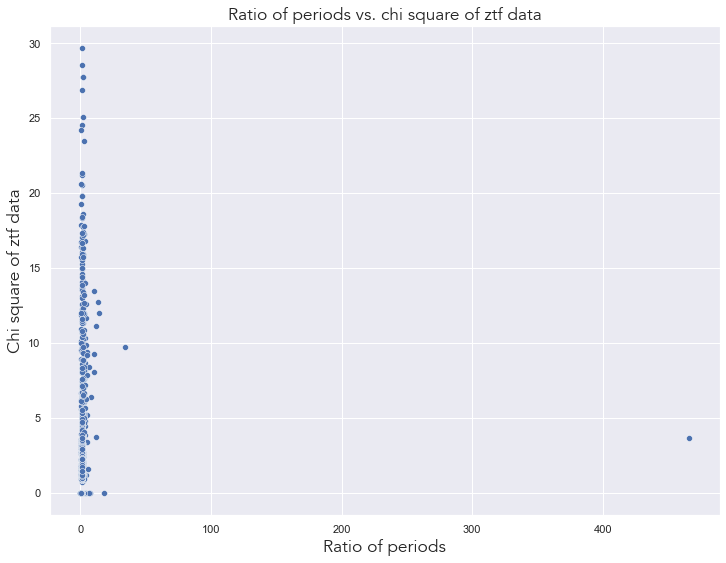

In [22]:
plt.figure(figsize=(12,9))
sns.scatterplot(LC_ANALYSIS, x='Pratio', y='ZPztf_chi2dofR')
plt.title('Ratio of periods vs. chi square of ztf data', fontproperties=font)
plt.xlabel('Ratio of periods', fontproperties=font)
plt.ylabel('Chi square of ztf data', fontproperties=font)
plt.show()

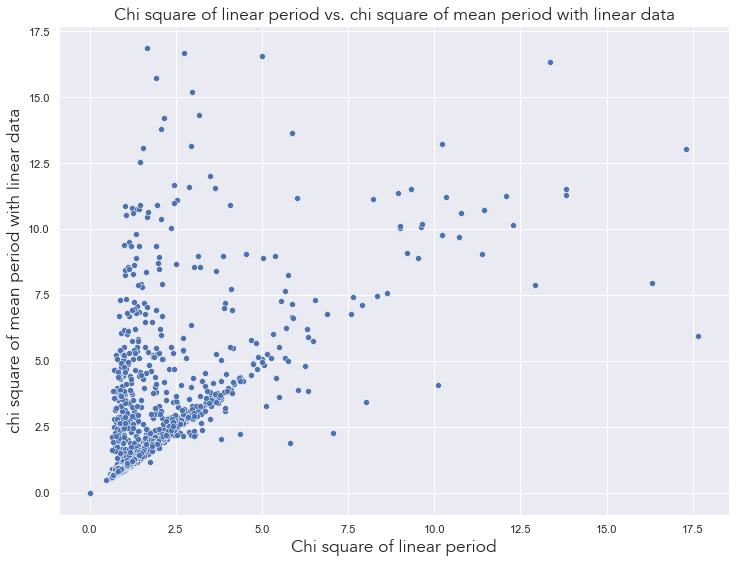

In [23]:
plt.figure(figsize=(12,9))
sns.scatterplot(LC_ANALYSIS, x='LPlin_chi2dofR', y='LPmean_chi2dofR')
plt.title('Chi square of linear period vs. chi square of mean period with linear data', fontproperties=font)
plt.xlabel('Chi square of linear period', fontproperties=font)
plt.ylabel('chi square of mean period with linear data', fontproperties=font)
plt.show()

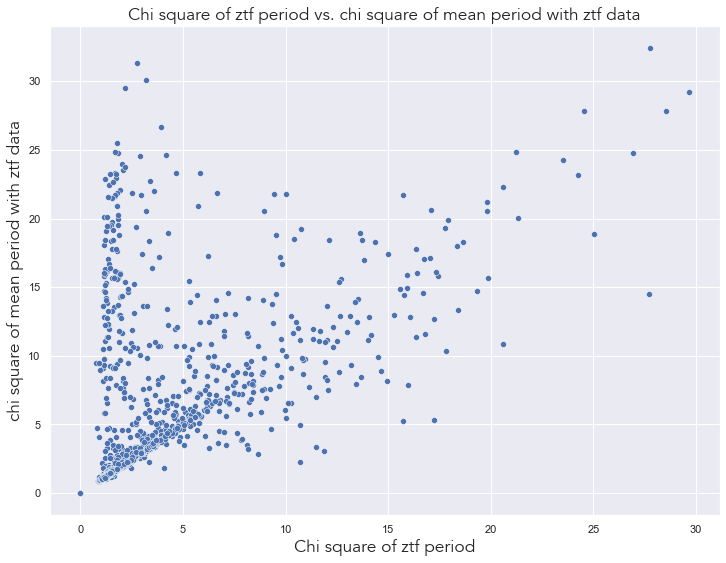

In [24]:
plt.figure(figsize=(12,9))
sns.scatterplot(LC_ANALYSIS, x='ZPztf_chi2dofR', y='ZPmean_chi2dofR')
plt.title('Chi square of ztf period vs. chi square of mean period with ztf data', fontproperties=font)
plt.xlabel('Chi square of ztf period', fontproperties=font)
plt.ylabel('chi square of mean period with ztf data', fontproperties=font)
plt.show()

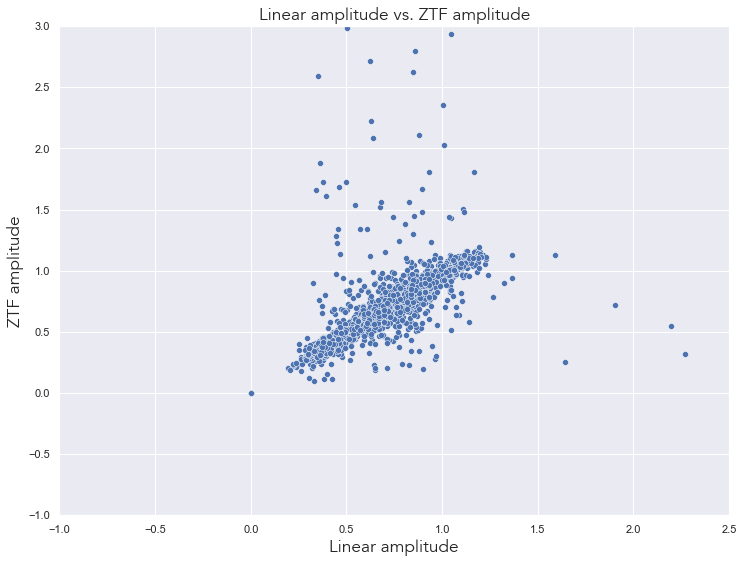

In [25]:
plt.figure(figsize=(12,9))
sns.scatterplot(LC_ANALYSIS, x='Lampl', y='Zampl')
plt.xlim([-1,2.5])
plt.ylim([-1,3])
plt.title('Linear amplitude vs. ZTF amplitude', fontproperties=font)
plt.xlabel('Linear amplitude', fontproperties=font)
plt.ylabel('ZTF amplitude', fontproperties=font)
plt.show()

In [27]:
l = LC_ANALYSIS.loc[LC_ANALYSIS['Zindicator'] == 1]
l.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPztf_chi2dofR,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit
19,303860,0.492145,0.492164,0.492155,1.000040,280.0,0.090758,3.474911,1.398451,0.100403,...,3.035580,0.056274,49.825915,3.438669,15.599545,0.768657,0,0.25,1.0,0.25
21,355767,0.521368,0.521363,0.521366,0.999991,180.0,0.103821,0.987307,0.878734,0.109992,...,2.030014,0.037770,6.269881,1.994488,16.344715,0.842194,0,0.25,1.0,0.25
23,418785,0.700122,0.700120,0.700121,0.999998,263.0,0.120176,1.443688,0.796597,0.117596,...,1.261994,0.035619,4.879155,1.245072,16.518551,0.544663,0,0.25,1.0,0.25
25,437483,0.699235,0.699234,0.699234,1.000000,316.0,0.117653,0.517548,0.685323,0.117550,...,1.045483,0.045664,1.699911,1.045334,16.500213,0.347478,0,0.25,1.0,0.25
41,813450,0.589389,0.589390,0.589389,1.000001,221.0,0.130989,1.978570,1.324242,0.131192,...,1.006288,0.022873,1.606273,0.994425,15.902661,0.652062,0,0.25,1.0,0.25


# Testing

In [ ]:
i = 294
verbose = True
# STEP 1: Gather the data
if verbose: print('Gathering data')
# --------------------------
# LINEAR
Lid = Lids[i]
if verbose: print(f'Lid: {Lid}   Index: {i}')

tL, mL, mLerr = data.get_light_curve(Lid).T
ra = rectascension[i]
dec = declination[i]

# ZTF
ZTFdata = getZTFlightcurve(ra, dec)
if verbose: 
    print(f'ZTF data >>> shape:{ZTFdata.shape}')
    print(f'ZTF data >>> columns:{ZTFdata.columns}')

# STEP 2: Calculating the periods + accessing the periodograms
if verbose: print('\nCalculating the periods + accessing the periodograms')
# ---------------------------------------------------------------
nterms = 3
Plinear, fL, pL = doPeriods(tL, mL, mLerr, nterms, lsPS=True)
if ZTFdata.empty:
    if verbose: print('ZTFdata is empty!')
    Pztf, fZ, pZ = 0,np.array(()),np.array(())
else:
    Pztf, fZ, pZ = getZTFperiod(ZTFdata, nterms, ZTFbands=['zg', 'zr', 'zi'], lsPS=True)

Pmean = (Plinear+Pztf)/2
Pratio = Pztf/Plinear
if verbose: 
    print(f'Pmean: {Pmean}')
    print(f'Pratio: {Pratio}')

Lindicator, Llimit = periodogram_blazhko(pL, 0.3, 0.2, 0.1,verbose=True)
if ZTFdata.empty==True:
    Zindicator, Zlimit = np.nan, np.nan
else:
    Zindicator, Zlimit = periodogram_blazhko(pZ, 0.3, 0.2, 0.1,verbose=True)